My other works
- [Data preparation Notebook](https://www.kaggle.com/code/itsuki9180/detect-sleep-states-dataprepare)
- [Training Notebook](https://www.kaggle.com/code/itsuki9180/detect-sleep-states-train) <- you are viewing now
- [Inference Notebook](https://www.kaggle.com/code/itsuki9180/detect-sleep-states-dataprepare)

# Import modules and Config

In [1]:
import pandas as pd
import numpy as np
import gc
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import os, glob
import joblib
import random
import math
from tqdm import tqdm 
from collections import OrderedDict

from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import argrelmax

from sklearn.metrics import mean_squared_error

from math import pi, sqrt, exp
import sklearn,sklearn.model_selection
import torch
from torch import nn,Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.optim import AdamW
from sklearn.metrics import average_precision_score
from timm.scheduler import CosineLRScheduler

from transformers import get_cosine_schedule_with_warmup

plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import ctypes

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Fundamental config
NOTDEBUG = True # False -> DEBUG, True -> normally train
WORKERS = os.cpu_count() // 2
N_FOLDS = 5
TRAIN_FOLD = 0
MAX_LEN = 2**14
USE_AMP = False
SEED = 86

In [4]:
# Model config
HIDDEN = 256 if NOTDEBUG else 16
EMB_DIM = 16
KS = 31 if NOTDEBUG else 7
N_BLKS = 5 if NOTDEBUG else 2
DROPOUT = 0.2

In [5]:
# Optimizer config
LR = 5e-4
WD = 1e-2
WARMUP_PROP = 0.1
# LR_INIT = 1e-4
# LR_MIN = 1e-5

In [6]:
# Train config
EPOCHS = 10
BS = 32
MAX_GRAD_NORM = 2.
GRAD_ACC = 32 // BS

In [7]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True
    # torch.backends.cudnn.benchmark = True

torch_fix_seed(SEED)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
def plot_history(history, model_path=".", show=True):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Training Loss")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss")
    plt.yscale('log')
    plt.title("Loss evolution")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, "loss_evo.png"))
    if show:
        plt.show()
    plt.close()

#     plt.figure()
#     plt.plot(epochs, history["valid_mAP"])
#     plt.title("Validation mAP evolution")
#     plt.xlabel("Epochs")
#     plt.ylabel("mAP")
#     plt.savefig(os.path.join(model_path, "mAP_evo.png"))
#     if show:
#         plt.show()
#     plt.close()

    plt.figure()
    plt.plot(epochs, history["lr"])
    plt.title("Learning Rate evolution")
    plt.xlabel("Epochs")
    plt.ylabel("LR")
    plt.savefig(os.path.join(model_path, "lr_evo.png"))
    if show:
        plt.show()
    plt.close()

# Define Model

In [10]:
def seq_block(in_features, out_features, ks=3, drop_rate=0.2, dilation=1):
    padding = ((ks-1)*dilation)//2
    return nn.Sequential(
        nn.Conv1d(in_features, out_features, ks, padding=padding, dilation=dilation),
        nn.BatchNorm1d(out_features),
        nn.LeakyReLU(0.2),
        nn.Dropout(drop_rate)
    )

class SimpleConvNet(nn.Module):
    def __init__(self, in_c=2, out_c=2, hidden=128, emb_dim=8, ks=3, n_blks=3, dropout=0.2):
        super(SimpleConvNet, self).__init__()
        
        self.hr_emb = nn.Embedding(24, emb_dim)
        self.fc1_hr = nn.Linear(emb_dim, emb_dim)
        self.fc2_hr = nn.Linear(emb_dim, emb_dim)
        
        self.fc_in = nn.Linear(in_c+emb_dim, hidden)
        self.blks = nn.Sequential(
            *[seq_block(hidden, hidden, ks, drop_rate=dropout, dilation=2**i) for i in range(n_blks)]
            )
        self.fc_out = nn.Linear(hidden, out_c)
        
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x, h):        
        e = self.hr_emb(h)
        e = self.fc1_hr(e)
        e = self.lrelu(e)
        e = self.fc2_hr(e)

        x = torch.cat([x, e.squeeze(2)], dim=-1)
        x = self.fc_in(x)
        
        x = x.permute(0,2,1)
        
        for b in self.blks:
            x = b(x)

        x = x.permute(0,2,1)
        
        x = self.fc_out(x)
        return x

# Define Dataset and Fold split

In [11]:
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
skf = StratifiedKFold(n_splits=N_FOLDS, random_state=SEED, shuffle=True)
# metadata = pd.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
metadata = data = pd.read_parquet("/kaggle/input/zzzs-lightweight-training-dataset-target/Zzzs_train.parquet")
unique_ids = metadata['series_id'].unique()
meta_cts = pd.DataFrame(unique_ids, columns=['series_id'])
for i, (train_index, valid_index) in enumerate(skf.split(X=meta_cts['series_id'], y=[1]*len(meta_cts))):
    if i != TRAIN_FOLD:
        continue
    print(f"Fold = {i}")
    train_ids = meta_cts.loc[train_index, 'series_id']
    valid_ids = meta_cts.loc[valid_index, 'series_id']
    print(f"Length of Train = {len(train_ids)}, Length of Valid = {len(valid_ids)}")
    
    if i == TRAIN_FOLD:
        break
        
train_fpaths = [f"/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/train_csvs/{_id}.csv" for _id in train_ids]
valid_fpaths = [f"/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/train_csvs/{_id}.csv" for _id in valid_ids]
train_ids[:5], train_fpaths[:5] ,len(train_fpaths)

Fold = 0
Length of Train = 28, Length of Valid = 7


(0    08db4255286f
 1    0a96f4993bd7
 2    0cfc06c129cc
 3    1087d7b0ff2e
 4    10f8bc1f7b07
 Name: series_id, dtype: object,
 ['/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/train_csvs/08db4255286f.csv',
  '/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/train_csvs/0a96f4993bd7.csv',
  '/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/train_csvs/0cfc06c129cc.csv',
  '/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/train_csvs/1087d7b0ff2e.csv',
  '/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/train_csvs/10f8bc1f7b07.csv'],
 28)

In [12]:
SIGMA = 720 #average length of day is 24*60*12 = 17280 for comparison
SAMPLE_FREQ = 12 # 1 obs per minute
class SleepDataset(Dataset):
    def __init__(
        self,
        folder,
        max_len=2**12,
        is_train=False,
        sample_per_epoch=10000
    ):
        self.enmo_mean = np.load('/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/enmo_mean.npy')
        self.enmo_std = np.load('/kaggle/input/itsuki-dataprepare-with-lightweight-gaussian-filte/enmo_std.npy')
        
        self.max_len = max_len
        
        self.is_train = is_train
        
        self.max_df_size = 0
        self.min_df_size = 1e9
        
        self.sample_per_epoch = sample_per_epoch
        
        self.feat_list = ['anglez','enmo']
        
        self.Xys = self.read_csvs(folder)        
        
        self.label_list = ['onset', 'wakeup']
        
        self.hour_feat= ['hour']
        
    def read_csvs(self, folder):
        res = []
        if type(folder) is str:
            files = glob.glob(f'{folder}/*.csv')
        else:
            files = folder
        for i, f in tqdm(enumerate(files), total=len(files), leave=False):
            df = pd.read_csv(f)
            df = self.norm_feat_eng(df, init=True if i==0 else False)
                
            res.append(df)
            self.max_df_size = max(self.max_df_size, len(df))
            self.min_df_size = min(self.min_df_size, len(df))
        return res

    def norm_feat_eng(self, X, init=False):
        X['anglez'] = X['anglez'] / 90.0
        X['enmo'] = (X['enmo'] - self.enmo_mean) / (self.enmo_std + 1e-12)
        
        for w in [1, 2, 4, 8, 16]:    
            X['anglez_shift_pos_' + str(w)] = X['anglez'].shift(w).fillna(0)
            X['anglez_shift_neg_' + str(w)] = X['anglez'].shift(-w).fillna(0)
            
            X['enmo_shift_pos_' + str(w)] = X['enmo'].shift(w).fillna(0)
            X['enmo_shift_neg_' + str(w)] = X['enmo'].shift(-w).fillna(0)
            
            if init:
                self.feat_list.append('anglez_shift_pos_' + str(w))
                self.feat_list.append('anglez_shift_neg_' + str(w))
                
                self.feat_list.append('enmo_shift_pos_' + str(w))
                self.feat_list.append('enmo_shift_neg_' + str(w))
            
        for r in [17, 33, 65]:
            tmp_anglez = X['anglez'].rolling(r, center=True)
            X[f'anglez_mean_{r}'] = tmp_anglez.mean()
            X[f'anglez_std_{r}'] = tmp_anglez.std()            
            
            tmp_enmo = X['enmo'].rolling(r, center=True)
            X[f'enmo_mean_{r}'] = tmp_enmo.mean()
            X[f'enmo_std_{r}'] = tmp_enmo.std()
            
            if init:
                self.feat_list.append(f'anglez_mean_{r}')
                self.feat_list.append(f'anglez_std_{r}')

                self.feat_list.append(f'enmo_mean_{r}')
                self.feat_list.append(f'enmo_std_{r}')
                
        X = X.fillna(0)
        
        return X.astype(np.float32)

    def gauss(self,n=SIGMA,sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
    
    def __len__(self):
        return self.sample_per_epoch if self.is_train else len(self.Xys)

    def __getitem__(self, index):
        if self.is_train:
            ind = np.random.randint(0, len(self.Xys))
            Xy = self.Xys[ind]
            
            X = Xy[self.feat_list].values.astype(np.float32)
            y = Xy[self.label_list].values.astype(np.float32)
            t = Xy[self.hour_feat].values.astype(np.int32)

            if len(Xy)+1<self.max_len:
                res = self.max_len - len(Xy) + 1
                X = np.pad(X, ((0, res), (0, 0)))
                y = np.pad(y, ((0, res), (0, 0)))
                t = np.pad(t, ((0, res), (0, 0)))

            start = np.random.randint(0, len(X)-self.max_len)

            X = X[start:start+self.max_len]
            y = y[start:start+self.max_len]    
            t = t[start:start+self.max_len]    

        else:
            Xy = self.Xys[index]
            X = Xy[self.feat_list].values.astype(np.float32)
            y = Xy[self.label_list].values.astype(np.float32)        
            t = Xy[self.hour_feat].values.astype(np.int32)
        return X, t, y

train_fpaths = train_fpaths if NOTDEBUG else train_fpaths[:50]
valid_fpaths = valid_fpaths if NOTDEBUG else valid_fpaths[:10]
sample_per_epoch = 20_000 if NOTDEBUG else 1_000

train_ds = SleepDataset(train_fpaths, max_len=MAX_LEN, is_train=True, sample_per_epoch=sample_per_epoch)
val_ds = SleepDataset(valid_fpaths, is_train=False)

In [13]:
np.save('feature_list.npy', train_ds.feat_list)

In [14]:
train_dl = DataLoader(
    train_ds,
    batch_size=BS,
    pin_memory=True,
    num_workers=WORKERS,
    shuffle=True,
    drop_last=True
)
val_dl = DataLoader(
    val_ds,
    batch_size=1,
    pin_memory=True,
    num_workers=WORKERS,
    shuffle=False,
    drop_last=False
)

# Train and Eval

In [15]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, alpha=1., gamma=2.):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = self.alpha * (1-BCE_EXP)**self.gamma * BCE
                       
        return focal_loss.mean()

In [16]:
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or np.any([v in name.lower()  for v in skip_list]):
            # print(name, 'no decay')
            no_decay.append(param)
        else:
            # print(name, 'decay')
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [17]:
model = SimpleConvNet(in_c=len(train_ds.feat_list), out_c=2, hidden=HIDDEN, emb_dim=EMB_DIM, ks=KS, n_blks=N_BLKS, dropout=DROPOUT).to(device)
model

SimpleConvNet(
  (hr_emb): Embedding(24, 16)
  (fc1_hr): Linear(in_features=16, out_features=16, bias=True)
  (fc2_hr): Linear(in_features=16, out_features=16, bias=True)
  (fc_in): Linear(in_features=50, out_features=256, bias=True)
  (blks): Sequential(
    (0): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(15,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(30,), dilation=(2,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(60,), dilation=(4,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, 

In [18]:
optimizer_parameters = add_weight_decay(model, weight_decay=WD, skip_list=['bias'])
optimizer = AdamW(optimizer_parameters, lr=LR, eps=1e-6, betas=(0.9, 0.999))

In [19]:
steps = len(train_dl)*EPOCHS
warmup_steps = int(steps*WARMUP_PROP)

print(steps, warmup_steps)

scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=steps,
                                            num_cycles=0.5)

dt = time.time()

model_path = './'

os.makedirs(model_path, exist_ok=True)

history = {
    "train_loss": [],
    "valid_loss": [],
    "lr": [],
}

best_valid_loss = 1e5

criterion = FocalLoss(alpha=1., gamma=2.)

6250 625


In [20]:
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # if you are using newer GPU, recommended dtype=torch.bfloat16 than half
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

In [21]:
es_step = 0

100%|██████████| 7/7 [00:15<00:00,  2.15s/it]


1/10 --  train_loss = 0.030794 --  valid_loss = 0.002022 --  time = 2668.307413s


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


2/10 --  train_loss = 0.001401 --  valid_loss = 0.001069 --  time = 2658.519145s


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


3/10 --  train_loss = 0.000933 --  valid_loss = 0.001005 --  time = 2657.855875s


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


4/10 --  train_loss = 0.000678 --  valid_loss = 0.001084 --  time = 2657.484674s


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


5/10 --  train_loss = 0.000464 --  valid_loss = 0.001241 --  time = 2657.181023s


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


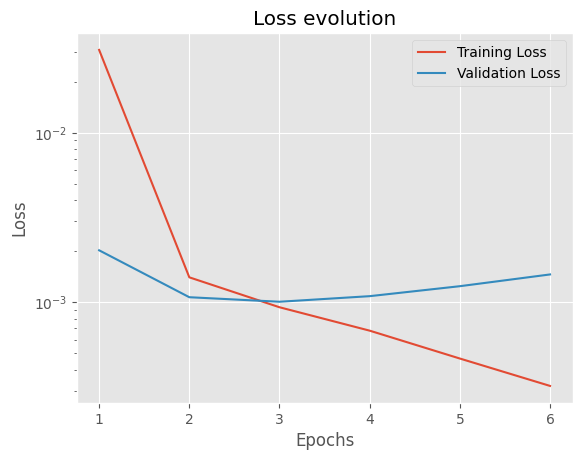

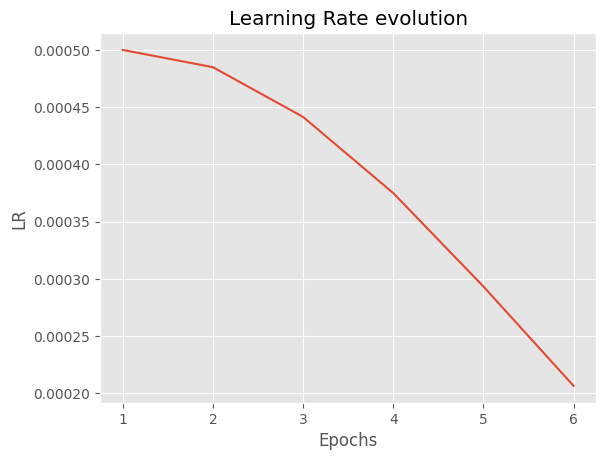

In [22]:
for epoch in range(EPOCHS):
    total_loss = 0.0
    model.train()
    optimizer.zero_grad()
    with tqdm(train_dl, leave=True) as pbar:
        for step, (X_batch, hr_batch, y_batch) in enumerate(pbar):
            X_batch = X_batch.to(device)
            hr_batch = hr_batch.to(device)
            y_batch = y_batch.to(device)           

            with autocast:
                pred = model(X_batch, hr_batch)
                loss = criterion(pred, y_batch)
                
                if torch.isnan(loss).any():
                    raise RuntimeError('Detected NaN.')
    
                total_loss += loss.item()
                if GRAD_ACC > 1:
                    loss = loss / GRAD_ACC
                        
                pbar.set_postfix(
                        OrderedDict(
                            loss=f'{loss.item()*GRAD_ACC:.6f}',
                            lr=f'{optimizer.param_groups[0]["lr"]:.3e}'
                        )
                    )
        
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)
    
            if (step + 1) % GRAD_ACC == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

        train_loss = total_loss/len(train_dl)
    

    total_loss = 0.0
    model.eval()
    with torch.no_grad():
        with tqdm(val_dl, leave=True) as pbar:
            for step, (X_batch, hr_batch, y_batch) in enumerate(pbar):
                X_batch = X_batch.to(device)
                hr_batch = hr_batch.to(device)
                y_batch = y_batch.to(device)

                with autocast:
                    pred = model(X_batch, hr_batch)
                    loss = criterion(pred, y_batch)

                total_loss += loss.item()
            
    valid_loss = total_loss/len(val_dl)
    
    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)
    history["lr"].append(optimizer.param_groups[0]["lr"])

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(
            model.state_dict(),
            os.path.join(model_path, f"model_best_fold-{TRAIN_FOLD}.pth"),
        )
        es_step = 0
        
    else:
        es_step += 1
        if es_step >= 3:
            break

    dt = time.time() - dt
    print(
        f"{epoch+1}/{EPOCHS} -- ",
        f"train_loss = {train_loss:.6f} -- ",
        f"valid_loss = {valid_loss:.6f} -- ",
        f"time = {dt:.6f}s",
    )
    dt = time.time()

plot_history(history, model_path=model_path)
history_path = os.path.join(model_path, "history.json")
with open(history_path, "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=4)

# Verification

In [23]:
model.eval()

SimpleConvNet(
  (hr_emb): Embedding(24, 16)
  (fc1_hr): Linear(in_features=16, out_features=16, bias=True)
  (fc2_hr): Linear(in_features=16, out_features=16, bias=True)
  (fc_in): Linear(in_features=50, out_features=256, bias=True)
  (blks): Sequential(
    (0): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(15,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(30,), dilation=(2,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(60,), dilation=(4,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, 

In [24]:
def lpf(wave, fs=12*60*24, fe=60, n=3):
    nyq = fs / 2.0
    b, a = signal.butter(1, fe/nyq, btype='low')
    for i in range(0, n):
        wave = signal.filtfilt(b, a, wave)
    return wave

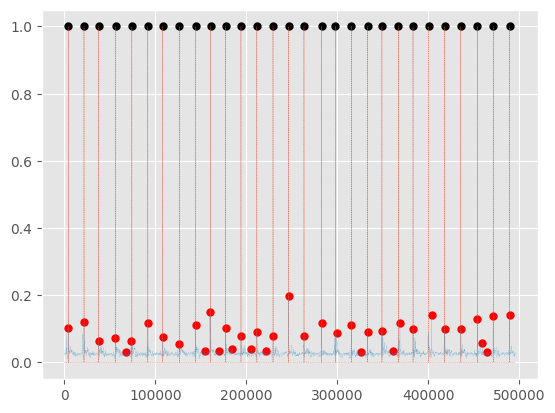

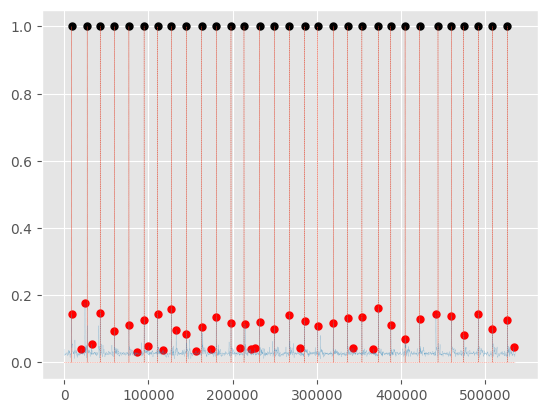

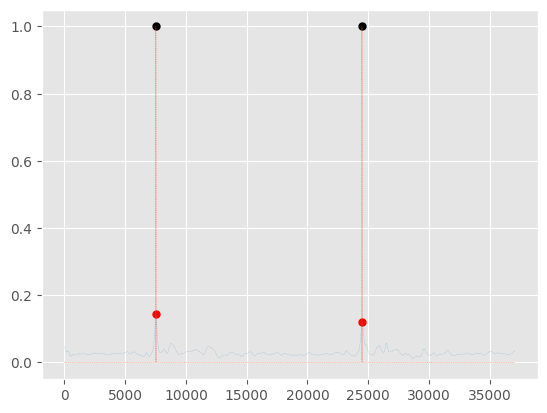

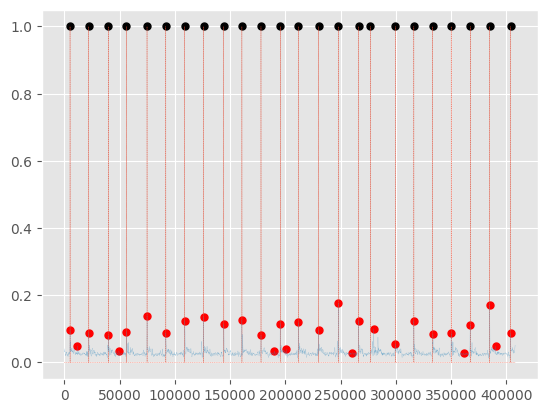

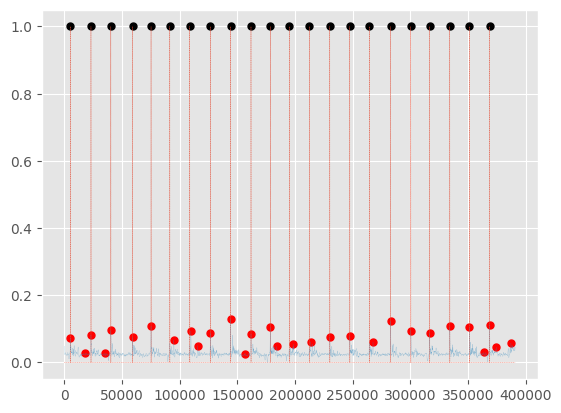

In [25]:
with torch.no_grad():
    for i, (x, h, y) in enumerate(val_dl):
        x = x.to(device)
        h = h.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_pred = model(x, h)

        y_pred = y_pred[0].sigmoid().cpu().numpy()
        y = y[0].cpu().numpy()
        
        before_RMSE = np.sqrt(mean_squared_error(y_pred, np.zeros_like(y_pred)))
        
        y_pred[:,0] = lpf(y_pred[:,0])
        y_pred[:,1] = lpf(y_pred[:,1])
        
        after_RMSE = np.sqrt(mean_squared_error(y_pred, np.zeros_like(y_pred)))

        decay_ratio = before_RMSE/after_RMSE
        
        y_pred *= decay_ratio

        candi = argrelmax(y_pred[:, 0], order=12*60*6) # 12*60*6 = 6hours
        gt = argrelmax(y[:,0], order=12*30)

        plt.plot(gt, y[gt, 0], marker='o', markersize=5, c="black")
        plt.plot(candi, y_pred[candi, 0], marker='o', markersize=5, c="red")    
        plt.plot(y[:, 0], lw=0.25, label="GT", linestyle="dashed")
        plt.plot(y_pred[:, 0], lw=0.25, label="pred", linestyle="dotted")
        plt.show()
        plt.close()

        if i==4: break